In [1]:
# !pip install 'zarr<3'
# !pip install timm
# !pip install openslide-python tiffslide
# !pip install cupy-cuda12x  # for CUDA 12.x
# !pip install geopandas pyarrow

In [2]:
# ALWAYS RUN THIS FIRST!
import os
import sys
from pathlib import Path

NOTEBOOK_DIR = Path("/rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest")
os.chdir(NOTEBOOK_DIR)
sys.path.insert(0, str(NOTEBOOK_DIR))

print(f"✅ Working directory: {os.getcwd()}")

✅ Working directory: /rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest


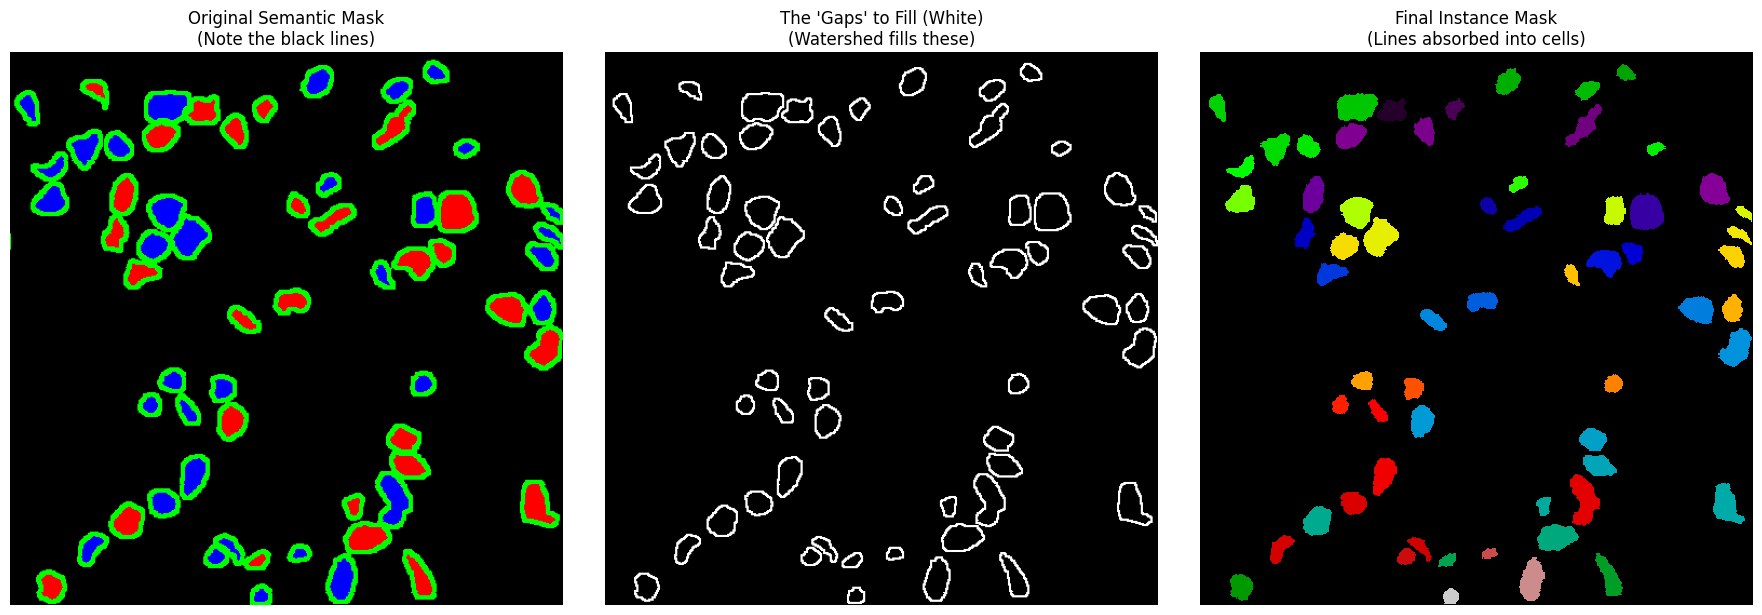

In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# --- Configuration ---
IMG_PATH = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/BC/train/6_0.png")

def create_full_instance_mask():
    if not IMG_PATH.exists():
        print(f"❌ Error: File not found at {IMG_PATH}")
        return

    # 1. Load Image
    img = cv2.imread(str(IMG_PATH))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 2. Extract Data
    panel1_ihc = img_rgb[:, 0:512, :]
    panel6_mask = img_rgb[:, 2560:3072, :] # The Semantic Mask
    
    # 3. Create Initial Markers from Red/Blue blobs
    #    Red (Pos) = Channel 0, Blue (Neg) = Channel 2
    pos_mask = (panel6_mask[:, :, 0] > 50).astype(np.uint8)
    neg_mask = (panel6_mask[:, :, 2] > 50).astype(np.uint8)
    
    # Combine (Just to find "All Cell Pixels")
    all_cells_mask = cv2.bitwise_or(pos_mask, neg_mask)
    
    # 4. Generate Instance IDs (The "Seeds")
    #    We perform connected components on Positive and Negative separately
    ret_pos, markers_pos = cv2.connectedComponents(pos_mask)
    ret_neg, markers_neg = cv2.connectedComponents(neg_mask)
    
    #    Combine them. We shift negative IDs so they don't clash.
    #    Markers now has: 0=Background, 1..N = Positive, N+1..M = Negative
    markers = markers_pos.copy()
    markers[markers_neg > 0] = markers_neg[markers_neg > 0] + (ret_pos - 1)
    
    # 5. Prepare for Watershed
    #    Watershed needs:
    #      > 0: Known Object (We have this in 'markers')
    #      = 1: Known Background (We need to define this!)
    #      = 0: Unknown Area (The lines we want to fill)
    
    #    Currently 'markers' has 0 for EVERYTHING that isn't a red/blue blob.
    #    We need to tell it that "Deep Background" is fixed, but "Lines" are fillable.
    
    #    Shift markers by +1 so that 1 becomes the new "Unknown" base, and 0 is reserved?
    #    Actually, standard OpenCV watershed convention:
    #      Any +ve integer: Known label.
    #      0: Unknown area (to be filled).
    
    #    So we need to set the "Sure Background" to a label (let's use 1).
    #    And we need to shift our Cell IDs to start from 2.
    markers = markers + 1 
    #    Now: 1=Old Background, 2..N=Cells.
    
    #    Identify "Unknown" region (The lines + immediate border).
    #    We define "Sure Background" as pixels far from cells.
    #    Dilate the cell mask to cover the gaps. Anything outside this dilation is SURE background.
    #    The "gap" size is likely small (3-5 pixels), so we dilate by ~5.
    sure_bg_mask = cv2.dilate(all_cells_mask, np.ones((5,5), np.uint8), iterations=1)
    sure_bg_mask = 1 - sure_bg_mask # Invert: 1=Far Background, 0=Cells+Lines
    
    #    Now we have:
    #    - markers: contains Cell IDs (where pixels are red/blue) and 1 (everywhere else)
    #    - We want markers to be:
    #         Cell IDs (inside cells)
    #         1        (far background)
    #         0        (the lines/gaps between cells)
    
    #    Current 'markers' is 1 everywhere outside cells.
    #    We want to set the "gap" region to 0.
    #    The "gap" region is where sure_bg_mask is 0 AND all_cells_mask is 0.
    unknown_region = (sure_bg_mask == 0) & (all_cells_mask == 0)
    markers[unknown_region] = 0
    
    # 6. Run Watershed
    #    It simulates water filling the "0" valleys from the numbered peaks.
    #    We use Panel 1 (IHC) as the topographic map to guide the edges slightly.
    cv2.watershed(panel1_ihc, markers)
    
    #    Watershed sets boundaries to -1. We can simply assign them to a neighbor or ignore (they are 1px thin).
    #    Let's fix -1 by converting to 1 (Background) or just taking abs().
    final_instances = markers.copy()
    final_instances[final_instances == -1] = 1 # Boundary becomes background
    
    #    Shift back: 1 (BG) -> 0. Cells -> 1..N
    final_instances = final_instances - 1
    
    # 7. Visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(panel6_mask)
    axes[0].set_title("Original Semantic Mask\n(Note the black lines)")
    axes[0].axis('off')
    
    # Show the "Unknown" area we identified (The lines)
    axes[1].imshow(unknown_region, cmap='gray')
    axes[1].set_title("The 'Gaps' to Fill (White)\n(Watershed fills these)")
    axes[1].axis('off')

    # Instance Mask
    masked_instances = np.ma.masked_where(final_instances == 0, final_instances)
    cmap = plt.cm.nipy_spectral
    cmap.set_bad(color='black')
    
    axes[2].imshow(masked_instances, cmap=cmap, interpolation='nearest')
    axes[2].set_title(f"Final Instance Mask\n(Lines absorbed into cells)")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    create_full_instance_mask()

In [2]:
import os
import glob
import numpy as np
import zarr
import pandas as pd
import cv2
from pathlib import Path
from tqdm import tqdm
import numcodecs
import random

# --- CONFIGURATION ---
BASE_PATH = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/BC")
OUTPUT_BASE = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/bcdata/zarr_data")

# Image settings
IMAGE_SIZE = 512
VAL_SPLIT_FROM_TRAIN = 0.10  # 10% of source train becomes validation
SEED = 42

cv2.setNumThreads(0)
random.seed(SEED)
np.random.seed(SEED)

# ---------------------------------------------------------------------
# 1. Helper: Convert Semantic Panel to Instance Mask (Watershed)
# ---------------------------------------------------------------------
def create_instance_mask_watershed(panel6_mask, panel1_ihc):
    """
    Converts the Panel 6 (Semantic) mask into an Instance Mask using Watershed.
    """
    # 1. Identify "Definite" Cells (The Seeds)
    pos_mask = (panel6_mask[:, :, 0] > 50).astype(np.uint8)
    neg_mask = (panel6_mask[:, :, 2] > 50).astype(np.uint8)
    
    # 2. Create Instance Markers
    num_pos, markers_pos = cv2.connectedComponents(pos_mask)
    num_neg, markers_neg = cv2.connectedComponents(neg_mask)
    
    markers = markers_pos.copy()
    markers[markers_neg > 0] = markers_neg[markers_neg > 0] + (num_pos - 1)
    
    # 3. Prepare for Watershed
    markers = markers + 1
    all_cells = cv2.bitwise_or(pos_mask, neg_mask)
    sure_bg = cv2.dilate(all_cells, np.ones((5,5), np.uint8), iterations=1)
    sure_bg = 1 - sure_bg 
    unknown_region = (sure_bg == 0) & (all_cells == 0)
    markers[unknown_region] = 0
    
    # 4. Run Watershed
    cv2.watershed(panel1_ihc, markers)
    
    # 5. Clean up
    markers[markers == -1] = 1
    final_mask = markers - 1
    final_mask = final_mask.astype(np.int32)
    
    return final_mask

# ---------------------------------------------------------------------
# 2. Process Single Image
# ---------------------------------------------------------------------
def process_single_image(img_path):
    """
    Process one BC DeepLIIF strip (3072x512).
    """
    try:
        strip = cv2.imread(str(img_path))
        if strip is None: return None
        strip_rgb = cv2.cvtColor(strip, cv2.COLOR_BGR2RGB)
        
        h, w, c = strip_rgb.shape
        if w != 3072 or h != 512: return None
            
        # Extract Panel 1 (Input) and Panel 6 (Mask)
        img_panel = strip_rgb[:, 0:512, :]
        mask_panel = strip_rgb[:, 2560:3072, :]
        
        instance_mask = create_instance_mask_watershed(mask_panel, img_panel)
        
        metadata = {
            'original_file': img_path.name,
            'original_width': 512,
            'original_height': 512,
            'num_cells': len(np.unique(instance_mask)) - 1
        }
        
        return {'image': img_panel, 'mask': instance_mask, 'metadata': metadata}
        
    except Exception as e:
        print(f"❌ Error processing {img_path.name}: {e}")
        return None

# ---------------------------------------------------------------------
# 3. Process List of Files -> Zarr Group
# ---------------------------------------------------------------------
def process_file_list(file_list, output_name):
    """
    output_name: e.g. 'bc_train', 'bc_val', 'bc_test'
    """
    if not file_list:
        print(f"⚠️  No files provided for {output_name}")
        return 0
        
    print(f"\n📂 Processing {output_name} ({len(file_list)} images)...")
    
    results = []
    for img_path in tqdm(file_list, desc=f"  {output_name}"):
        res = process_single_image(img_path)
        if res is not None:
            results.append(res)
            
    if not results:
        return 0
        
    # Aggregate
    all_imgs = np.stack([r['image'] for r in results], axis=0)
    all_masks = np.stack([r['mask'] for r in results], axis=0)
    all_meta = [r['metadata'] for r in results]
    
    # Save Zarr
    output_dir = OUTPUT_BASE / output_name
    if output_dir.exists():
        import shutil
        shutil.rmtree(output_dir)
    os.makedirs(output_dir, exist_ok=True)
    
    compressor = numcodecs.Blosc(cname='zstd', clevel=3)
    
    z_img = zarr.open_array(str(output_dir / 'images.zarr'), mode='w', shape=all_imgs.shape, chunks=(1, 512, 512, 3), dtype='uint8', compressor=compressor)
    z_img[:] = all_imgs
    
    z_mask = zarr.open_array(str(output_dir / 'nuclei_masks.zarr'), mode='w', shape=all_masks.shape, chunks=(1, 512, 512), dtype='int32', compressor=compressor)
    z_mask[:] = all_masks
    
    pd.DataFrame(all_meta).to_csv(output_dir / 'metadata.csv', index=False)
    
    print(f"   ✅ Saved {output_name}: {len(all_imgs)} images.")
    return len(all_imgs)

# ---------------------------------------------------------------------
# 4. Main Execution
# ---------------------------------------------------------------------
def main():
    print("=" * 70)
    print("🔬 BC (DeepLIIF) Conversion")
    print("   1. Source 'val' folder   -> bc_test")
    print("   2. Source 'train' folder -> Split into bc_train (90%) / bc_val (10%)")
    print("=" * 70)
    
    OUTPUT_BASE.mkdir(parents=True, exist_ok=True)
    
    # --- STEP 1: Process TEST Set (from source 'val' folder) ---
    source_val_dir = BASE_PATH / "val"
    if not source_val_dir.exists(): source_val_dir = BASE_PATH / "validation" # fallback

    if source_val_dir.exists():
        test_files = sorted(list(source_val_dir.glob("*.png")))
        print(f"\n📂 Found {len(test_files)} source validation images (Using as TEST SET).")
        process_file_list(test_files, "bc_test")
    else:
        print("⚠️  Source 'val' folder not found.")

    # --- STEP 2: Process TRAIN/VAL Split (from source 'train' folder) ---
    source_train_dir = BASE_PATH / "train"
    
    if source_train_dir.exists():
        all_train_files = sorted(list(source_train_dir.glob("*.png")))
        
        # Shuffle
        random.shuffle(all_train_files)
        
        # Split 10% for Validation
        n_val = int(len(all_train_files) * VAL_SPLIT_FROM_TRAIN)
        if n_val == 0 and len(all_train_files) > 1: n_val = 1
            
        val_files = all_train_files[:n_val]      # New bc_val
        train_files = all_train_files[n_val:]    # New bc_train
        
        print(f"\n📊 Splitting Source Train Data ({len(all_train_files)} total):")
        print(f"   Train Group (bc_train): {len(train_files)} images")
        print(f"   Val Group   (bc_val):   {len(val_files)} images")
        
        process_file_list(train_files, "bc_train")
        process_file_list(val_files, "bc_val")
        
    else:
        print("⚠️  Source 'train' folder not found.")

    print("\n" + "=" * 70)
    print("✅ PROCESSING COMPLETE")

if __name__ == "__main__":
    main()

🔬 BC (DeepLIIF) Conversion
   1. Source 'val' folder   -> bc_test
   2. Source 'train' folder -> Split into bc_train (90%) / bc_val (10%)

📂 Found 66 source validation images (Using as TEST SET).

📂 Processing bc_test (66 images)...


  bc_test: 100%|██████████| 66/66 [00:03<00:00, 16.93it/s]


   ✅ Saved bc_test: 66 images.

📊 Splitting Source Train Data (385 total):
   Train Group (bc_train): 347 images
   Val Group   (bc_val):   38 images

📂 Processing bc_train (347 images)...


  bc_train: 100%|██████████| 347/347 [00:18<00:00, 19.00it/s]


   ✅ Saved bc_train: 347 images.

📂 Processing bc_val (38 images)...


  bc_val: 100%|██████████| 38/38 [00:02<00:00, 18.01it/s]


   ✅ Saved bc_val: 38 images.

✅ PROCESSING COMPLETE


🔬 BC Dataset Zarr Verification

🔍 Verifying: TRAIN
   Path: /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/bcdata/zarr_data/bc_train
   ✅ Images Shape: (385, 512, 512, 3)
   ✅ Masks Shape:  (385, 512, 512)
   📊 Visualizing samples at indices: [5, 82, 230]...


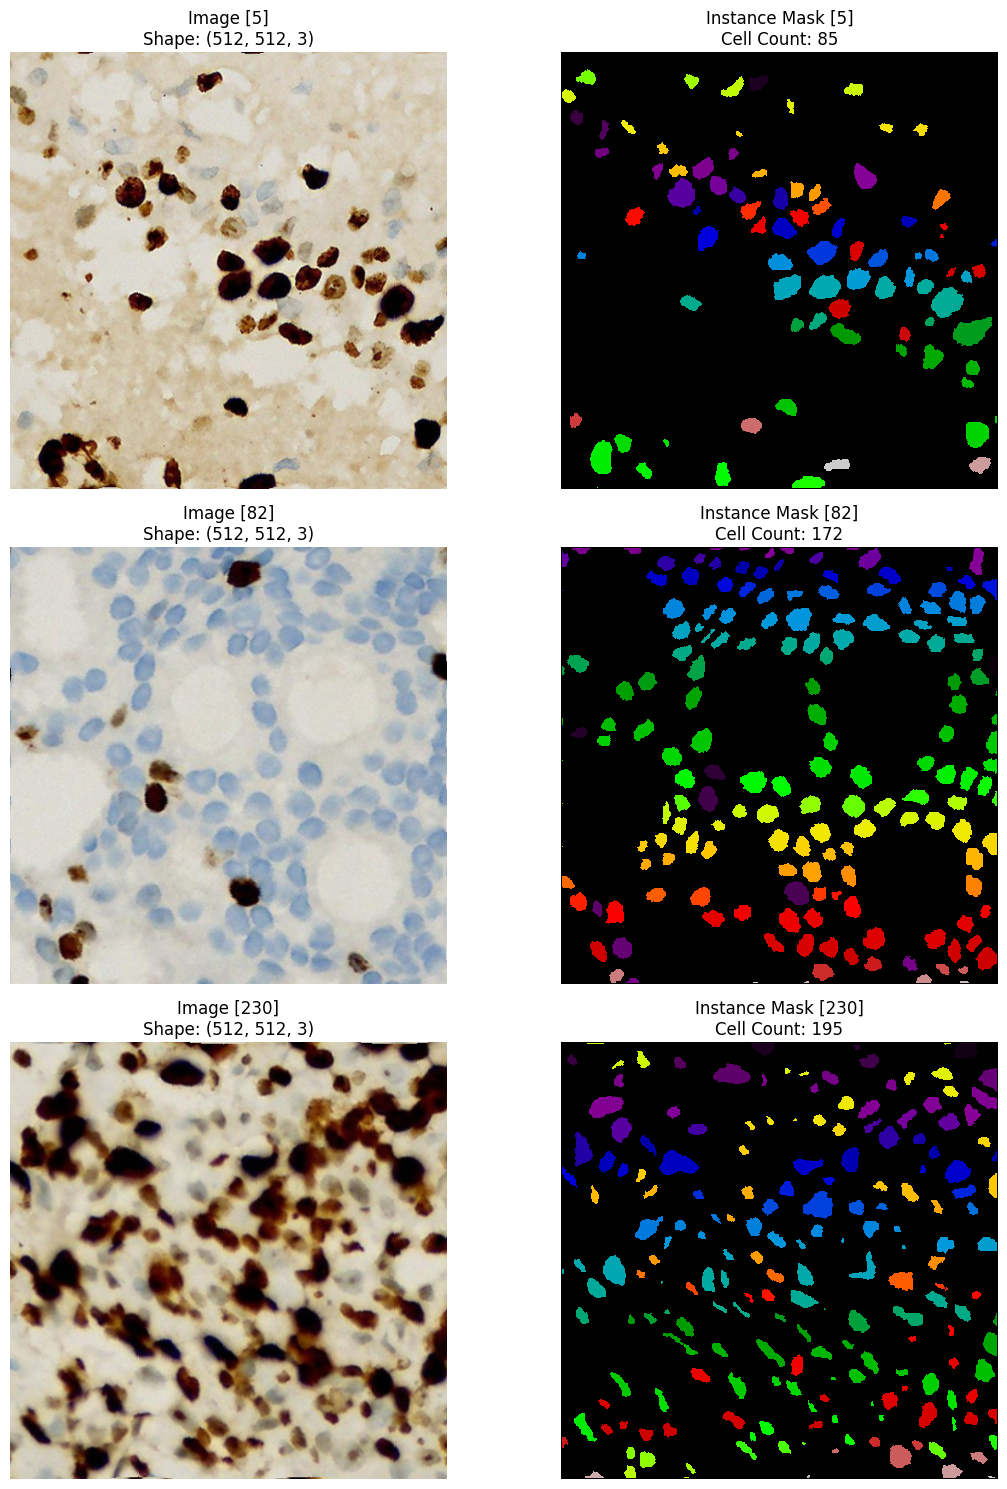


🔍 Verifying: VAL
   Path: /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/bcdata/zarr_data/bc_val
   ✅ Images Shape: (66, 512, 512, 3)
   ✅ Masks Shape:  (66, 512, 512)
   📊 Visualizing samples at indices: [1, 6, 20]...


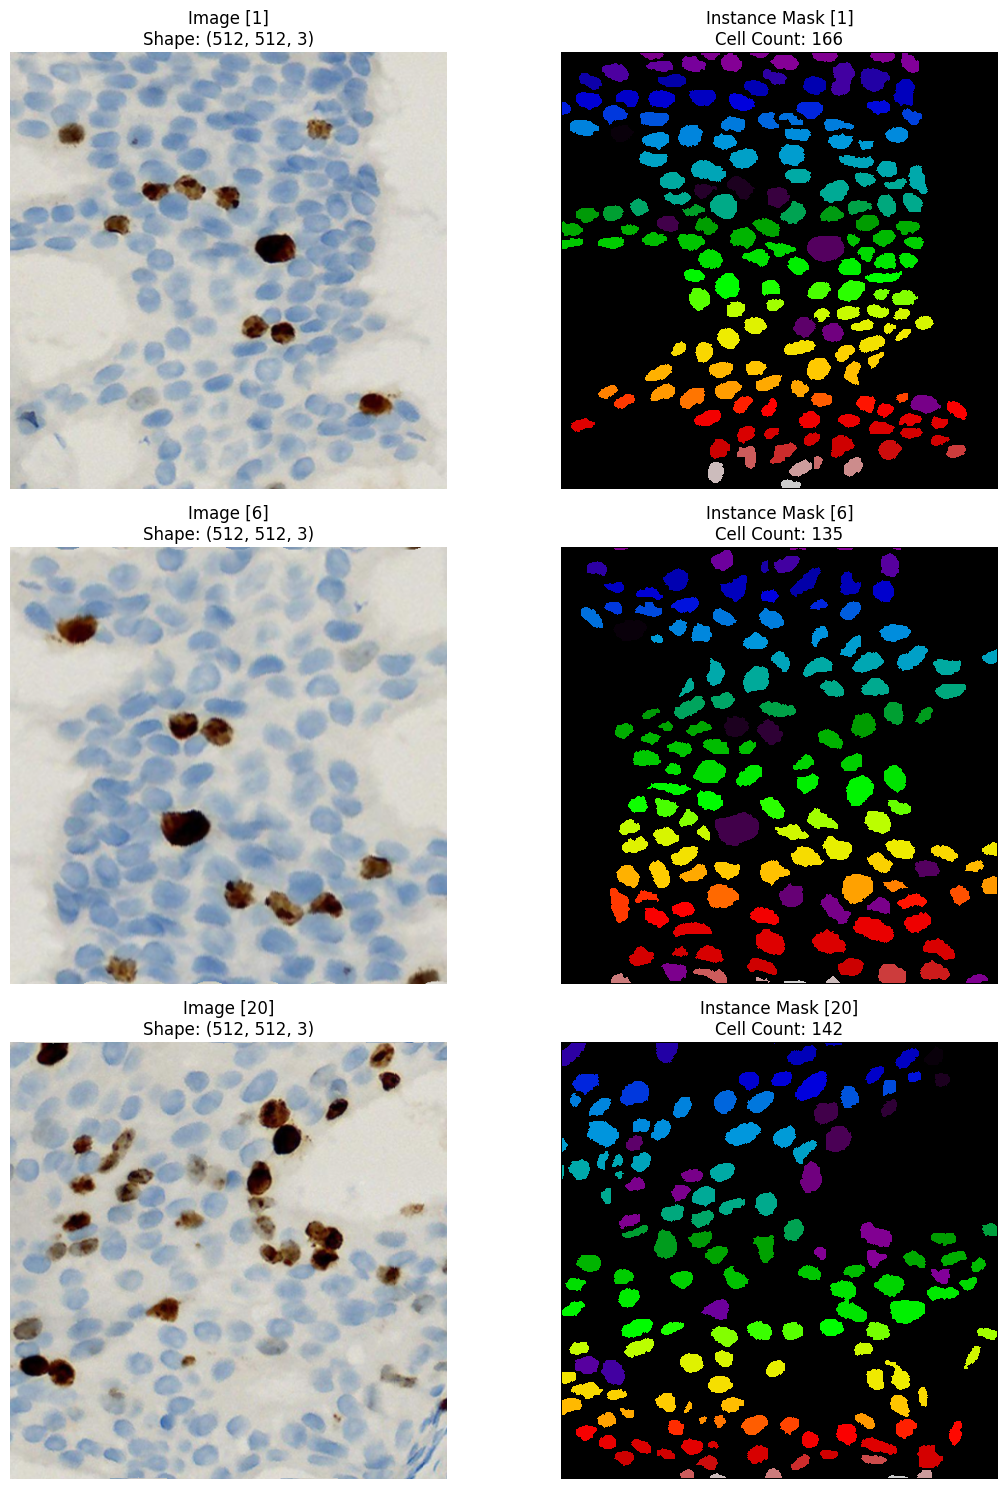

In [10]:
import zarr
import matplotlib.pyplot as plt
import numpy as np
import random
from pathlib import Path

# --- CONFIGURATION ---
# Point this to the output folder you defined in the previous script
DATA_PATH = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/bcdata/zarr_data")

def verify_dataset(split_name):
    split_dir = DATA_PATH / f"bc_{split_name}"
    
    print(f"\n🔍 Verifying: {split_name.upper()}")
    print(f"   Path: {split_dir}")
    
    if not split_dir.exists():
        print("❌ Dataset not found!")
        return

    # 1. Open Zarr Arrays (Read-Only)
    try:
        z_img = zarr.open(str(split_dir / 'images.zarr'), mode='r')
        z_mask = zarr.open(str(split_dir / 'nuclei_masks.zarr'), mode='r')
    except Exception as e:
        print(f"❌ Error opening Zarr files: {e}")
        return

    # 2. Print Basic Stats
    num_images = z_img.shape[0]
    print(f"   ✅ Images Shape: {z_img.shape}")
    print(f"   ✅ Masks Shape:  {z_mask.shape}")
    
    if num_images == 0:
        print("⚠️  Dataset is empty.")
        return

    # 3. Visualize Random Samples
    num_samples = 3
    indices = sorted(random.sample(range(num_images), min(num_samples, num_images)))
    
    print(f"   📊 Visualizing samples at indices: {indices}...")

    fig, axes = plt.subplots(len(indices), 2, figsize=(12, 5 * len(indices)))
    if len(indices) == 1: axes = [axes] # Handle single sample case

    for i, idx in enumerate(indices):
        # Load data from Zarr
        img = z_img[idx]
        mask = z_mask[idx]
        
        # Calculate stats for this specific image
        unique_ids = np.unique(mask)
        num_cells = len(unique_ids) - 1 if 0 in unique_ids else len(unique_ids)
        
        # Plot Image
        ax_img = axes[i][0] if len(indices) > 1 else axes[0]
        ax_img.imshow(img)
        ax_img.set_title(f"Image [{idx}]\nShape: {img.shape}")
        ax_img.axis('off')
        
        # Plot Mask (Spectral colormap shows instance separation)
        ax_mask = axes[i][1] if len(indices) > 1 else axes[1]
        
        # Mask background (0) so it appears white/black
        masked_data = np.ma.masked_where(mask == 0, mask)
        cmap = plt.cm.nipy_spectral
        cmap.set_bad(color='black')
        
        ax_mask.imshow(masked_data, cmap=cmap, interpolation='nearest')
        ax_mask.set_title(f"Instance Mask [{idx}]\nCell Count: {num_cells}")
        ax_mask.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    print("="*60)
    print("🔬 BC Dataset Zarr Verification")
    print("="*60)
    
    # Check Train
    verify_dataset("train")
    
    # Check Val
    verify_dataset("val")